<a href="https://colab.research.google.com/github/arthurtabbal/predict-sales-kaggle/blob/main/predict_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary steps to download the dataset using the !kaggle API:

1) Open the link https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview , sign in at Kaggle, join the competition and accept the terms.

2) Access your account at https://www.kaggle.com/nome-de-usuario/account , download the token file kaggle.json and save on your machine.

3) Upload the file at the cell below:

In [ ]:
# (helper cell to cleanup the filesystem) -- DO NOT RUN THIS OUTSIDE COLAB -- just in case
 
!rm -rf /root/.kaggle
!rm -rf *

In [ ]:
from google.colab import files

# Upload the kaggle.json file with your token
files.upload()

# Move the file to the directory expected by the kaggle API
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/ -f

# Set permissions so that only the user can read / write
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset and unzip the files
!kaggle competitions download -c competitive-data-science-predict-future-sales --quiet
!echo "Ay" | unzip -q "*.zip"

# List only the .csv files
!ls | grep -v zip | grep csv


4 archives were successfully processed.
item_categories.csv
items.csv
sales_train.csv
sample_submission.csv
shops.csv
test.csv


In [ ]:
# Import data science libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# For each csv file, we create a data frame with the same name

item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
sales_train = pd.read_csv('sales_train.csv')
sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

## Opening and Inspecting the Files

In [ ]:
# Lets first import a library that connects with the google translator API, since our files are in Russian

!pip install googletrans==4.0.0-rc1 --quiet
from googletrans import Translator

translator = Translator()

# And define a helper 'translate' function // use only on heads and tails, or any small frame, because it's slow

def translate(df):
  
  fields= list(df.columns.values)
  df = df.copy()
  for field in fields:
    try:
      df[field] = df[field].apply(lambda value: translator.translate(value).text)
    except:
      pass
  return df



     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 1.2 MB 22.9 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
# Look into the files - we already know the number of unique values, etc...

translate(shops.sample(5))

,shop_name,shop_id
48,"Tomsk TRC ""Emerald City""",48
47,"Surgut TRC ""City Mall""",47
54,"Himki Tc ""Mega""",54
37,"Novosibirsk Tc ""Mega""",37
6,"Voronezh (Plekhanovskaya, 13)",6


In [ ]:
translate(item_categories.sample(5))

,item_category_name,item_category_id
20,Games - PS4,20
15,Gaming Consoles - Xbox 360,15
45,Books - Audiobooks 1C,45
72,Gifts - Figures,72
8,Tickets (digit),8


In [ ]:
translate(items.sample(5))

,item_name,item_id,item_category_id
13379,Kompl.Vopr.Serd.exam.1С: Salary and personnel ...,13379,49
19719,TOM AND JERRY.The collection is vol.4 WB (region),19719,40
3073,"DYING LIGHT [Xbox One, Russian subtitles]",3073,24
18886,Smurfs 2 (BD),18886,37
8110,Agatha Christie 10 years of life 2lp,8110,58


In [ ]:
items.nunique()

item_name           22170
item_id             22170
item_category_id       84
dtype: int64

In [ ]:
sales_train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2139792,20.11.2014,22,56,1556,2999.0,1.0
808967,07.08.2013,7,29,18451,199.0,1.0
1050456,12.11.2013,10,31,3335,2499.0,1.0
285891,21.03.2013,2,21,1905,249.0,1.0
434059,02.04.2013,3,37,18200,299.0,1.0


In [ ]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
sales_train['item_price'].sort_values(ascending=False)

1163158    307980.0000
885138      59200.0000
1488135     50999.0000
2327159     49782.0000
2910156     42990.0000
              ...     
673155          0.0900
611400          0.0875
579766          0.0700
608763          0.0700
484683         -1.0000
Name: item_price, Length: 2935849, dtype: float64

In [ ]:
sales_train['item_cnt_day'].sort_values(ascending=False)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
            ...  
940092       -6.0
59156        -6.0
2048519      -9.0
1835454     -16.0
1057907     -22.0
Name: item_cnt_day, Length: 2935849, dtype: float64

# Treating the Data and Feature Engineering

In [ ]:
# Let's get rid of price and count outliers, also drop items that were returned
# Also, according the evaluation page at Kaggle, values will be clipped to the range [0, 20]
# So we can do that now to help the training of our model later

mask = (sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < 700) & (sales_train['item_price'] < 50000) & (sales_train['item_price'] > 0)
sales = sales_train[mask].copy()
sales['item_cnt_day'].clip(0, 20, inplace=True)
sales.drop_duplicates(inplace=True)
display(sales_train.shape)
display(sales.shape)

(2935849, 6)

(2928481, 6)

In [ ]:
# Might be a good idea to list the average values of each item in each shop

prices_shop = sales.groupby(['item_id', 'shop_id']).agg({'item_price':'median'})
prices_shop.rename(columns=lambda x: 'price_in_shop', inplace=True)
prices_shop.drop_duplicates(inplace=True)
prices_shop.reset_index(inplace=True)
prices_shop

,item_id,shop_id,price_in_shop
0,0,54,58.000
1,1,55,4490.000
2,3,54,79.000
3,5,54,28.000
4,6,54,100.000
...,...,...,...
10625,22140,42,284.085
10626,22150,19,181.450
10627,22153,18,178.925
10628,22164,3,705.250


In [ ]:
# And average price in the total market

avg_prices = sales.groupby(['item_id']).agg({'item_price':'median'})
avg_prices.rename(columns=lambda x: 'market_price', inplace=True)
avg_prices.drop_duplicates(inplace=True)
avg_prices.reset_index(inplace=True)
avg_prices

,item_id,market_price
0,0,58.000
1,1,4490.000
2,3,79.000
3,5,28.000
4,6,100.000
...,...,...
1485,21994,5259.000
1486,22036,130.415
1487,22098,7.000
1488,22153,220.380


In [ ]:
# So now we can list the difference between the two
# That represents the advantage or disadvantage a certain shop has in selling some specific item

prices = pd.merge(prices_shop, avg_prices, how='left', on='item_id')
prices['delta_price'] = prices['price_in_shop'] - prices['market_price']
prices.drop(columns=['market_price', 'price_in_shop'], inplace=True)
prices.fillna(0, inplace=True)
prices[prices['delta_price'] != 0]

,item_id,shop_id,delta_price
7,27,1,492.000
8,27,2,100.500
9,27,3,-400.000
10,27,4,-900.000
11,27,5,-550.000
...,...,...,...
10561,21994,19,1441.000
10562,21994,30,1590.500
10563,21994,38,-131.500
10564,21994,59,694.675


In [ ]:
# We'll be using only the ID values given in test.csv

test.shape

(214200, 3)

In [ ]:
# So we merge delta price with the test set

test_prices = pd.merge(test, prices, how='left', on=['item_id', 'shop_id'])
test_prices.fillna(0, inplace=True)
test_prices[test_prices['delta_price'] != 0]

,ID,shop_id,item_id,delta_price
196,196,5,6676,-1500.000
217,217,5,6496,-54.690
225,225,5,7792,546.295
524,524,5,1545,-1501.000
594,594,5,31,-200.000
...,...,...,...,...
212174,212174,45,1515,198.000
212725,212725,45,8330,-120.960
212918,212918,45,1544,-1401.000
213035,213035,45,13401,-351.000


In [ ]:
# Now we take the columns in test and merge them to the full train dataframe

sales_ID = pd.merge(test_prices, sales.drop(columns=['item_price','date']).drop_duplicates(), how='left', on=['shop_id', 'item_id'])
sales_ID.fillna(0, inplace=True)

In [ ]:
# Use sklearn to tokenize the string features into several 'contains <word>' boolean features

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# Helper function for tokenizing, allowing us to optimize max_features for each field

def tokenize(df_data, df_words, field, max_features):
  vectorizer.max_features = max_features
  tokens = vectorizer.fit(df_words[field])
  vector = tokens.transform(df_words[field])
  words = pd.DataFrame(vector.toarray(), columns=tokens.get_feature_names())
  df_tokenized = df_words.join(words)
  return pd.merge(df_data, df_tokenized, how='left')


In [ ]:
# Identify the category of each item and merge

items_with_cat = pd.merge(items, item_categories, how='left', on='item_category_id').drop(columns=['item_name', 'item_category_name'])
items_with_cat.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [ ]:
# Tokenize this frame with tokens from the categories

item_category_tokens = tokenize(items_with_cat, item_categories, 'item_category_name', 40).drop(columns='item_category_name')
item_category_tokens.head()

,item_id,item_category_id,1с,360,blu,cd,live,one,pc,ps2,ps3,ps4,psp,psvita,ray,xbox,аксессуары,аудиокниги,билеты,для,дома,игровые,игры,издания,карты,кино,книги,консоли,литература,музыка,настольные,носители,обучающие,оплаты,открытки,офиса,подарки,программы,производства,служебные,цифра,чистые
0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
2,2,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# These are the ones we extracted

translate(item_category_tokens.columns.to_frame())

,0
item_id,item_id
item_category_id,item_category_id
1с,1c
360,360
blu,blu
cd,cd
live,live
one,one
pc,pc
ps2,ps2


In [ ]:
# Do the same thing with the shops. Max features is set to 40 in both cases after trial and error.

shop_tokens = tokenize(shops, shops, 'shop_name', 40).drop(columns='shop_name')
shop_tokens.head()

,shop_id,56,ii,буденовский,век,воронеж,горизонт,жуковский,казань,красноярск,магазин,мега,мегацентр,молл,москва,новгород,новосибирск,омск,орджоникидзе,островной,пав,паркхаус,перловский,плаза,плехановская,рио,ростовнадону,самара,сити,спб,тк,трк,трц,тц,тюмень,ул,уфа,фран,центральный,чкалова,якутск
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Shop tokens

translate(shop_tokens.columns.to_frame())

,0
shop_id,shop_id
56,56
ii,ii
буденовский,Budennovsky
век,century
воронеж,Voronezh
горизонт,horizon
жуковский,Zhukovsky
казань,Kazan.
красноярск,Krasnoyarsk


In [ ]:
# Merge these new features to the full dataframe

sales_tokens = pd.merge(sales_ID, item_category_tokens, how='left', on='item_id').merge(shop_tokens, how='left', on='shop_id')
sales_tokens.fillna(0, inplace=True)
sales_tokens

,ID,shop_id,item_id,delta_price,date_block_num,item_cnt_day,item_category_id,1с,360,blu,cd,live,one,pc,ps2,ps3,ps4,psp,psvita,ray,xbox,аксессуары,аудиокниги,билеты,для,дома,игровые,игры,издания,карты,кино,книги,консоли,литература,музыка,настольные,носители,обучающие,оплаты,открытки,...,56,ii,буденовский,век,воронеж,горизонт,жуковский,казань,красноярск,магазин,мега,мегацентр,молл,москва,новгород,новосибирск,омск,орджоникидзе,островной,пав,паркхаус,перловский,плаза,плехановская,рио,ростовнадону,самара,сити,спб,тк,трк,трц,тц,тюмень,ул,уфа,фран,центральный,чкалова,якутск
0,0,5,5037,0.0,20.0,1.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,5,5037,0.0,22.0,1.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,5,5037,0.0,23.0,1.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,5,5037,0.0,24.0,1.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,5,5037,0.0,28.0,1.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787960,214198,45,19648,0.0,0.0,0.0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
787961,214199,45,969,0.0,17.0,1.0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
787962,214199,45,969,0.0,17.0,2.0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
787963,214199,45,969,0.0,18.0,1.0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Now we can generate our target. It is the sum of all items sold in a given month for each (shop_id, item_id) tuple
# I call this the poor man's time series

sales_by_month = sales_tokens.pivot_table(values='item_cnt_day', index='ID', columns='date_block_num', aggfunc='sum', fill_value=0)
sales_by_month.clip(0, 20, inplace=True)
sales_by_month.reset_index(inplace=True)
sales_by_month

date_block_num,ID,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,1,1,1
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1
214196,214196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214197,214197,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
214198,214198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Use the series as features in the full data frame

sales_full = pd.merge(sales_tokens.drop(columns=['item_cnt_day', 'date_block_num']).drop_duplicates(), sales_by_month, how='right', on='ID')
sales_full.drop_duplicates(inplace=True)
sales_full

,ID,shop_id,item_id,delta_price,item_category_id,1с,360,blu,cd,live,one,pc,ps2,ps3,ps4,psp,psvita,ray,xbox,аксессуары,аудиокниги,билеты,для,дома,игровые,игры,издания,карты,кино,книги,консоли,литература,музыка,настольные,носители,обучающие,оплаты,открытки,офиса,подарки,...,ул,уфа,фран,центральный,чкалова,якутск,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0,5,5037,0.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1,1,0
1,1,5,5320,0.0,55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5,5233,0.0,19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,1,1,1
3,3,5,5232,0.0,23,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,5,5268,0.0,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1
214196,214196,45,16188,0.0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214197,214197,45,15757,0.0,55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
214198,214198,45,19648,0.0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Sklearn

In [ ]:
# The most awaited moment
from sklearn.metrics import mean_squared_error

### XGBoost Regressor

In [ ]:
# XGBoost is really unbeatable in terms of speed
# Even without the GPU - I've reached Google's limits - the hist method is really fast in fitting

from xgboost import XGBRegressor

In [ ]:
# I did no GridSearch. Some parameters were taken from Daniel Malheiros's notebook.
# Other I tuned manually by trial and error

XGB = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.5, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1,
             tree_method='hist')

In [ ]:
# Converting everything to float for 

X = sales_full.astype('float')

In [ ]:
# Train and validate on month 33 - because we're ready for submission
# Prior training was made on 32 and validation on 33

X_train = X.drop([0, 1, 33], axis=1).values
X_test = X.drop([0, 1, 33], axis=1).values

y_train = X[33].values
y_test = X[33].values


In [ ]:
# This runs incredibly fast

XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.5, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='hist',
             verbosity=1)

array([0.54006106, 0.09106109, 0.50008714, ..., 0.10710678, 0.09302413,
       0.09304985], dtype=float32)

array([0., 0., 1., ..., 0., 0., 0.])

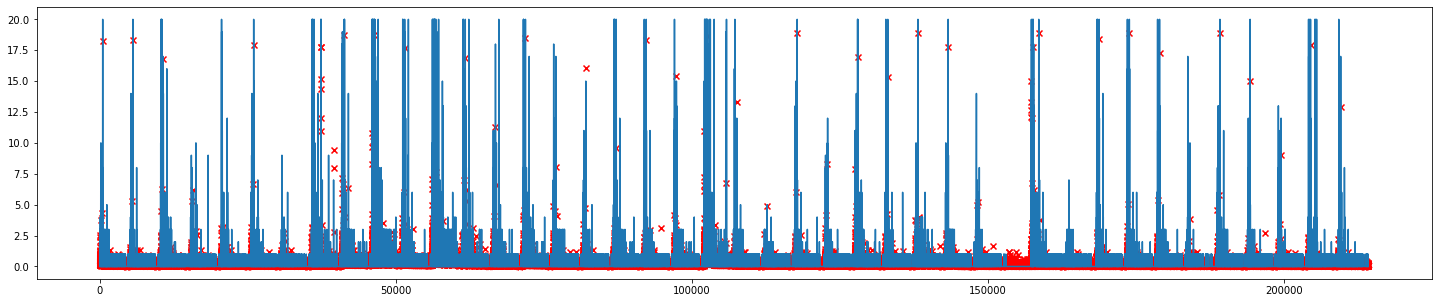

 Current RMSE :  0.609772929079304


In [ ]:
# Caveman plot of ground truth X predictions

y_pred = XGB.predict(X_test)
display(y_pred)
display(y_test)

plt.figure(figsize=(25,5))
plt.plot(range(len(y_test)), y_test)
plt.scatter(range(len(y_pred)), y_pred, marker='x', c='r')
plt.show()

print(' Current RMSE : ', mean_squared_error(y_test, y_pred, squared=False))

In [ ]:
# Make our prediction

X_submission = X.drop([0, 1, 2], axis=1).values
y_submission = XGB.predict(X_submission)
y_submission

array([0.3648762 , 0.09106109, 0.6025702 , ..., 0.10309508, 0.09302413,
       0.09304985], dtype=float32)

In [ ]:
# Submission is ready for shipping

submission = sample_submission.copy()
submission['item_cnt_month'] = y_submission
submission

,ID,item_cnt_month
0,0,0.364876
1,1,0.091061
2,2,0.602570
3,3,0.167787
4,4,0.459994
...,...,...
214195,214195,0.225919
214196,214196,0.079837
214197,214197,0.103095
214198,214198,0.093024


In [ ]:
# Here it is

submission_file = submission.to_csv('submission.csv', index=False)
files.download('submission.csv')